# 14 MCP를 활용한 에이전트 구현

In [1]:
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
from langchain_upstage import UpstageEmbeddings
# 환경변수를 불러옴
load_dotenv()

# Upstage의 SOLAR 임베딩 모델을 초기화한다
embedding = UpstageEmbeddings(
    model='solar-embedding-1-large'  
)

In [2]:
from langgraph.graph import StateGraph, MessagesState
    
graph_builder = StateGraph(MessagesState)

In [3]:
from langchain_pinecone import PineconeVectorStore

index_name = 'house-tax-index'

vector_store = PineconeVectorStore.from_existing_index(
                       index_name=index_name,
                       embedding=embedding, )

retriever = vector_store.as_retriever( search_kwargs={"k": 3})

/Users/jasonkang/personal/langgraph-book/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

In [5]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain import hub
from langchain_core.tools import tool
rag_prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


tax_deductible_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | small_llm
    | StrOutputParser()
)

deductible_question = f'주택에 대한 종합부동산세 과세표준의 공제액을 알려주세요'

user_deduction_prompt = """아래 [Context]는 주택에 대한 종합부동산세의 공제액에 관한 내용입니다. 
사용자의 질문을 통해서 가지고 있는 주택수에 대한 공제액이 얼마인지 금액만 반환해주세요

[Context]
{tax_deductible_response}

[Question]
질문: {question}
답변: 
"""
user_deduction_prompt_template = PromptTemplate(
    template=user_deduction_prompt,
    input_variables=['tax_deductible_response', 'question']
)
user_deduction_chain = (user_deduction_prompt_template
    | small_llm
    | StrOutputParser()
)

@tool
def get_tax_deduction(question: str) -> str:
    """사용자의 부동산 소유 현황에 대한 질문을 기반으로 세금 공제액을 계산합니다.
    
    이 도구는 다음 두 단계로 작동합니다:
    1. tax_deductible_chain을 사용하여 일반적인 세금 공제 규칙을 검색
    2. user_deduction_chain을 사용하여 사용자의 특정 상황에 규칙을 적용

    Args:
        question (str): 부동산 소유에 대한 사용자의 질문
        
    Returns:
        str: 세금 공제액 (예: '9억원', '12억원')
    """
    tax_deductible_response = tax_deductible_chain.invoke(deductible_question)
    tax_deductible = user_deduction_chain.invoke({
        'tax_deductible_response': tax_deductible_response, 
        'question': question
    })
    return tax_deductible

In [6]:
from langchain_core.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name='real_estate_tax_retriever',
    description='Contains information about real estate tax up to December 2024',
)

In [7]:
from langchain import hub

rag_prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    """
    Formats a list of documents into a single string by joining their content.
    
    Args:
        docs: List of Document objects containing page_content
        
    Returns:
        str: Concatenated string of document contents separated by newlines
    """
    return "\n\n".join(doc.page_content for doc in docs)

tax_base_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | small_llm
    | StrOutputParser()
)
tax_base_question = '주택에 대한 종합부동산세 과세표준을 계산하는 방법은 무엇인가요? 수식으로 표현해서 수식만 반환해주세요'

@tool
def get_tax_base() -> str:
    """종합부동산세 과세표준을 계산하기 위한 공식을 검색하고 형식화합니다.
    
    이 도구는 RAG(Retrieval Augmented Generation) 방식을 사용하여:
    1. 지식 베이스에서 과세표준 계산 규칙을 검색
    2. 검색한 규칙을 수학 공식으로 형식화

    Args:
        question (str): 사용자의 질문 (미리 정의된 질문이 사용됨)
        
    Returns:
        str: 과세표준 계산 공식
    """
    tax_base_response = tax_base_chain.invoke(tax_base_question)
    return tax_base_response


In [8]:
from langchain_core.prompts import ChatPromptTemplate

@tool
def get_house_tax(tax_base_question: str, market_value_rate_question: str, tax_deductible_question: str, question: str) -> str:
    """수집된 모든 정보를 사용하여 최종 종합부동산세액을 계산합니다.
    
    이 도구는 다음 정보들을 결합하여 최종 세액을 계산합니다:
    1. 과세표준 계산 공식
    2. 공정시장가액비율
    3. 공제액
    4. 세율표

    Args:
        tax_base_question (str): 과세표준 계산 공식
        market_value_rate_question (str): 공정시장가액비율
        tax_deductible_question (str): 공제액
        question (str): 부동산 세금 계산에 대한 사용자의 질문
        
    Returns:
        str: 설명이 포함된 최종 세금 계산액
    """
    house_tax_prompt = ChatPromptTemplate.from_messages([
    ('system', f'''과세표준 계산방법: {tax_base_question}
    공정시장가액비율: {market_value_rate_question}
    공제액: {tax_deductible_question}

    위의 공식과 아래 세율에 관한 정보를 활용해서 세금을 계산해주세요.
    세율: {{tax_rate}}
    '''),
        ('human', '{question}')
    ])

    house_tax_chain = (
        {
            'tax_rate': retriever | format_docs,
            'question': RunnablePassthrough()
        }
        | house_tax_prompt
        | llm
        | StrOutputParser()
    )

    house_tax = house_tax_chain.invoke(question)
    return house_tax

In [9]:
# MCP 클라이언트를 생성하기 위한 MultiServerMCPClient 클래스 임포트
from langchain_mcp_adapters.client import MultiServerMCPClient

# 여러 MCP 서버에 연결할 수 있는 클라이언트 인스턴스 생성
mcp_client = MultiServerMCPClient({
    "house_tax_tools": {
        "command": "python",
        "args": ["./mcp_server.py"],
        "transport": "stdio",
    },
})


In [10]:
from langgraph.prebuilt import ToolNode

# MCP 서버에서 도구 목록 가져오기
mcp_tool_list = await mcp_client.get_tools()

# 전체 도구 목록 구성 (MCP 도구 + 로컬 도구)
tool_list = mcp_tool_list + [get_tax_deduction, get_tax_base, get_house_tax]

# 도구 기능이 활성화된 LLM 생성
llm_with_tools = llm.bind_tools(tool_list)

# LangGraph용 도구 노드 생성
tool_node = ToolNode(tool_list)

In [11]:
mcp_tool_list

[StructuredTool(name='add', description='두 숫자를 더합니다', args_schema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'addArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x1462d6480>),
 StructuredTool(name='get_market_value_rate', description="사용자의 부동산 상황에 적용되는 공정시장가액비율을 결정합니다.\n    \n    이 도구는:\n    1. 현재 공정시장가액비율 정보가 포함된 검색 결과를 사용\n    2. 사용자의 특정 상황(보유 부동산 수, 부동산 가치)을 분석\n    3. 적절한 공정시장가액비율을 백분율로 반환\n\n    Args:\n        question (str): 부동산 소유에 대한 사용자의 질문\n        \n    Returns:\n        str: 공정시장가액비율 백분율 (예: '60%', '45%')\n    ", args_schema={'properties': {'question': {'title': 'Question', 'type': 'string'}}, 'required': ['question'], 'title': 'get_market_value_rateArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_too

In [12]:
tool_list

[StructuredTool(name='add', description='두 숫자를 더합니다', args_schema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'addArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x1462d6480>),
 StructuredTool(name='get_market_value_rate', description="사용자의 부동산 상황에 적용되는 공정시장가액비율을 결정합니다.\n    \n    이 도구는:\n    1. 현재 공정시장가액비율 정보가 포함된 검색 결과를 사용\n    2. 사용자의 특정 상황(보유 부동산 수, 부동산 가치)을 분석\n    3. 적절한 공정시장가액비율을 백분율로 반환\n\n    Args:\n        question (str): 부동산 소유에 대한 사용자의 질문\n        \n    Returns:\n        str: 공정시장가액비율 백분율 (예: '60%', '45%')\n    ", args_schema={'properties': {'question': {'title': 'Question', 'type': 'string'}}, 'required': ['question'], 'title': 'get_market_value_rateArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_too

In [13]:
from langchain_core.messages import SystemMessage


def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    system_message_content = """당신의 역할은 주택에 대한 종합부동산세를 계산하는 것입니다. 
    사용자의 질문이 들어오면, 사용자의 질문을 바탕으로 종합부동산세를 계산해주세요.
    종합부동산세를 계산하기 위해서는 과세표준을 어떻게 계산할지 파악해야하고, 
    사용자에 질문에 따른 공제액을 파악해야 하고, 
    사용자에 질문에 따른 공정시장가액비율을 파악해야 합니다.
    이 세가지를 파악하고 나면, 종합부동산세를 계산해주세요.
    """
    system_message = SystemMessage(content=system_message_content)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': [response]}

In [14]:
graph_builder.add_node(agent)
graph_builder.add_node('tools', tool_node)

In [15]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition


graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    tools_condition
)
graph_builder.add_edge('tools', 'agent')

In [16]:
graph = graph_builder.compile()

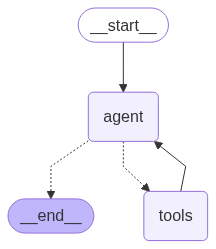

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
async def process_stream(stream_generator):
    """
    비동기 스트림 제너레이터를 처리하는 유틸리티 함수
    
    Args:
        stream_generator: LangGraph의 astream() 메서드가 반환하는 비동기 제너레이터
        
    Returns:
        list: 스트림에서 수신한 모든 청크들의 리스트
    """
    results = []
    try:
        # 비동기 제너레이터를 async for로 순회
        async for chunk in stream_generator:
            # 각 청크는 딕셔너리 형태로 단일 키를 가진다.
            # 키는 그래프의 노드 이름을 나타낸다. (예: 'agent', 'tools')
            key = list(chunk.keys())[0]
            
            if key == 'agent':
                # Agent 노드에서 생성된 메시지 처리
                # content가 비어있는 경우는 도구 호출을 준비하는 상태
                agent_message = chunk['agent']['messages'][0]
                
                # 일반 텍스트 응답인 경우 content 필드에 내용이 있다.
                # 도구 호출 준비 상태인 경우 additional_kwargs에 도구 호출 정보가 포함된다.
                content = agent_message.content if agent_message.content != '' else agent_message.additional_kwargs
                print(f"'agent': '{content}'")
            
            elif key == 'tools':
                # Tools 노드에서 생성된 메시지 처리
                # 도구 실행 결과는 여러 개의 메시지로 구성될 수 있다.
                for tool_msg in chunk['tools']['messages']:
                    print(f"'tools': '{tool_msg.content}'")
            
            # 모든 청크를 저장하여 나중에 최종 결과 확인 가능
            results.append(chunk)
            
        return results
        
    except Exception as e:
        # 스트림 처리 중 발생하는 예외를 포착
        # 네트워크 오류, 타임아웃 등의 상황에서도 안정적으로 처리
        print(f"Error processing stream: {e}")
        return results

In [ ]:
from langchain_core.messages import HumanMessage
question = '집이 13억일 때 세금은 얼마인가요?'
stream_generator = graph.astream({'messages': [HumanMessage(content=question)]})
print(stream_generator)

all_chunks = await process_stream(stream_generator)

# Pinecone에서 오류가 발생하여 retrieveal을 위해 도구가 여러 번 호출된다.
if all_chunks:
    final_result = all_chunks[-1]
    print("\nFinal result:", final_result)

<async_generator object Pregel.astream at 0x1462f0400>
'agent': '{'tool_calls': [{'id': 'call_aT2PKqloCXXteWXEDf7Q20Sg', 'function': {'arguments': '{}', 'name': 'get_tax_base'}, 'type': 'function'}, {'id': 'call_CiLki0SGLkaqlbxuASQfjJ02', 'function': {'arguments': '{"question": "집이 13억일 때 공정시장가액비율은 얼마인가요?"}', 'name': 'get_market_value_rate'}, 'type': 'function'}, {'id': 'call_CgA3Vhvn9hsVkS8vssvSGBsI', 'function': {'arguments': '{"question": "집이 13억일 때 세금 공제액은 얼마인가요?"}', 'name': 'get_tax_deduction'}, 'type': 'function'}], 'refusal': None}'
'tools': '(주택 공시가격 - 공제금액) * 공정시장가액비율'
'tools': '60%'
'tools': 'Error: InternalServerError("Error code: 500 - {'error': {'message': 'The server had an error while processing your request. Sorry about that!', 'type': 'server_error', 'param': None, 'code': None}}")
 Please fix your mistakes.'
'agent': '{'tool_calls': [{'id': 'call_82xm0GRr5DNAn9MylSWtOXBb', 'function': {'arguments': '{"question":"집이 13억일 때 세금 공제액은 얼마인가요?"}', 'name': 'get_tax_deduction'